# Задача 6. Компьютерное зрение: задача сегментации

Обучаем Сегментацию:
- https://colab.research.google.com/drive/1eUIOnLFB_9_6CJ3dVZxY9TV_gCqDAmaV?authuser=1#scrollTo=SjKfL5X_RbzH --- тут мы обучали на большом датасете одну эпоху.
- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

Мы хотим обучить наш unet на небольшом датасете. Нужно заполнить репорт и сделать выводы.
Чтобы успеть сделать много экспериментов нужна видеокарта. Можно использовать colab, тут есть бесплатные gpu ресурсы --- так будет быстрее.

- [x] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- [x] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- [x] Попробовать улучшить качество изменяя архитектуру.
- [x] * (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?
- [x] * (**+3 балла**) Сделать unet с pretrained энкодером (можно взять vgg или resnet18/34), сравнить с предыдущими пунктами.

In [1]:
import gc
import os
import random

from copy import copy

import torch
import pandas as pd
import seaborn as sns

from torch import nn
from torch.utils.data import Dataset
from torchvision import io
from torchvision.transforms import functional
from torchvision import transforms
from torchmetrics import JaccardIndex
from torch.utils.data import DataLoader, Subset
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange

In [2]:
torch.manual_seed(77137);
random.seed(3241);

## UNET
Реализация модели UNET

In [3]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, padding: int):
        super().__init__()
        self.double_conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv_block(x)


class Encoder(nn.Module):
    def __init__(self, in_channels: int, n_down: int, channels_factor: int = 2, padding: int = 1):
        super().__init__()

        self.enc_layers = nn.ModuleList([DoubleConvBlock(in_channels, in_channels * channels_factor, padding)])
        for _ in range(n_down):
            in_channels *= channels_factor
            self.enc_layers.append(
                nn.Sequential(
                    nn.MaxPool2d(2, 2),
                    DoubleConvBlock(in_channels, in_channels * channels_factor, padding),
                )
            )

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        results = []
        for layer in self.enc_layers:
            x = layer(x)
            results.append(x)
        return results


class Decoder(nn.Module):
    def __init__(self, in_channels: int, n_up: int, channels_divisor: int = 2, padding: int = 1):
        super().__init__()

        self.dec_layers = nn.ModuleList()
        for _ in range(n_up):
            out_channels = in_channels // channels_divisor
            self.dec_layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                DoubleConvBlock(in_channels, out_channels, padding),
            ]
            in_channels = out_channels

    def forward(self, x: torch.Tensor, residuals: list[torch.Tensor]) -> torch.Tensor:
        assert len(residuals) == len(self.dec_layers) // 2
        for (up_conv, double_conv), residual in zip(zip(self.dec_layers[::2], self.dec_layers[1::2]), residuals[::-1]):
            x = up_conv(x)

            h_diff = residual.size(dim=2) - x.size(dim=2)
            assert 0 <= h_diff <= 1
            w_diff = residual.size(dim=3) - x.size(dim=3)
            assert 0 <= w_diff <= 1
            if h_diff > 0 or w_diff > 0:
                x = nn.functional.pad(x, [0, w_diff, 0, h_diff])

            x = torch.cat([residual, x], dim=1)

            x = double_conv(x)
        return x


class UNET(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1, n_levels: int = 4):
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, n_down=n_levels)
        self.decoder = Decoder(in_channels=in_channels * (2 ** (n_levels + 1)), n_up=n_levels)
        self.out_conv = nn.Conv2d(in_channels=in_channels * 2, out_channels=out_channels, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        *residuals, x = self.encoder(x)
        x = self.decoder(x, residuals)
        x = self.out_conv(x)
        return x

## Train/Test split
Создадим набор классов-декораторов, в которые будем оборачивать датасет

- `BaseDataset` - просто датасет, выдает кортеж из картинки и маски
- `ShuffledDataset` - датасет-декоратор, выдает перемешанные значения из данного датасета
- `SliceDataset` - датасет-декоратор, выдает срез значение из данного датасета
- `AugmentedDataset` - датасет-декоратоа, позволяет применить геометрическую трансформацию к картинке и маске, а затем трансформацию цвета к картинке
- `PaddedDataset` - датасет, где все картинки выдаются с размером 800x608, чтобы быть совместимыми с моделями, где нужно иметь разрешение кратное 32

С помощью комбинаций данных классов будем выражать следующие датасеты


In [4]:

class BaseDataset(Dataset):
    def __init__(self, images_path, masks_path):
        self.images = self.__get_files(images_path)
        self.masks = self.__get_files(masks_path)

    def __get_files(self, directory):
        files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        return sorted(files)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = io.read_image(str(self.images[index])) / 255
        mask = io.read_image(str(self.masks[index])) / 255
        return image, mask


class ShuffledDataset(Dataset):
    def __init__(self, base_dataset, shuffle_seed):
        self._base_dataset = base_dataset
        random.seed(shuffle_seed)
        self._index_shuffle = list(range(len(self._base_dataset)))
        random.shuffle(self._index_shuffle)

    def __len__(self):
        return len(self._base_dataset)
    
    def __getitem__(self, index):
        return self._base_dataset[self._index_shuffle[index]]


class SliceDataset(Dataset):
    def __init__(self, base_dataset, pick_begin, pick_end):
        self._base_dataset = base_dataset
        self._pick_begin = pick_begin
        self._pick_end = pick_end

    def __len__(self):
        return min(self._pick_end - self._pick_begin, len(self._base_dataset))
    
    def __getitem__(self, index):
        return self._base_dataset[self._pick_begin + index]


class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, geometry_transform, color_transform):
        self._base_dataset = base_dataset
        self._gtransform = geometry_transform
        self._ctransform = color_transform
    
    def __len__(self):
        return len(self._base_dataset)
    
    def __getitem__(self, index):
        image, mask = self._base_dataset[index]
        return self._ctransform(self._gtransform(image)), self._gtransform(mask)


class PaddedDataset(Dataset):
    def __init__(self, base_dataset):
        self._base_dataset = base_dataset
        self._transformation = transforms.Resize((800, 608))
    
    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, index):
        image, mask = self._base_dataset[index]
        return self._transformation(image), self._transformation(mask)


Создадим train/test сплит, где 80% данных - тренировочные, 20% - тестовые

Для этого используем `SliceDataset`, `ShuffledDataset` и `BaseDataset`

In [5]:
def create_train_test_split():
    images = "../datasets/dataset/images"
    masks = "../datasets/dataset/masks"
    test_ratio = 0.2

    dataset = BaseDataset(images, masks)
    dataset = ShuffledDataset(dataset, 340597)
    data_len = len(dataset)
    test_amount = int(test_ratio * data_len)
    test_dataset = SliceDataset(dataset, 0, test_amount)
    train_dataset = SliceDataset(dataset, test_amount, data_len)

    print("Сделан train/test split")
    print(f"Размер train: {len(train_dataset)}")
    print(f"Размер test: {len(test_dataset)}")

    return test_dataset, train_dataset

In [6]:

def display_images(images):
    _, axes = plt.subplots(ncols=len(images))
    for index, image in enumerate(images):
        axes[index].imshow(functional.to_pil_image(image))
        axes[index].axis("off")
    plt.show()


## Содержимое датасетов

Сделан train/test split
Размер train: 1600
Размер test: 400


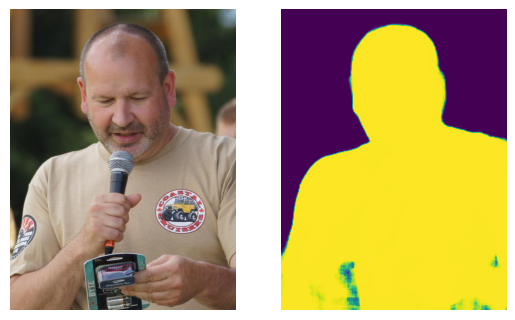

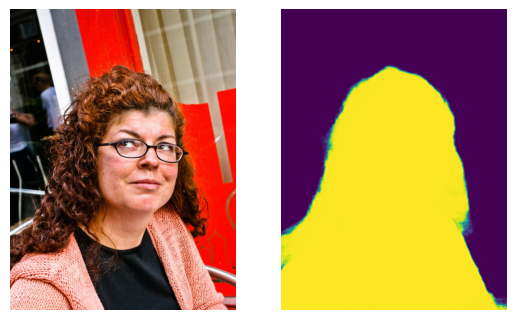

In [7]:
test_dataset, train_dataset = create_train_test_split()

display_images(test_dataset[0])
display_images(train_dataset[0])

## Инструменты для обучения сети

Создадим функцию потерь и функциб дял подсчета Jaccard Index

Создадим функции для отрисовки статистики, тренировки с кросс-валидацией, тестирования

In [8]:
loss_fn = nn.BCEWithLogitsLoss()
jaccard_fn = JaccardIndex(task="binary")

In [9]:
def display_statistics(stats, title):
    figure, (loss_axis, jaccard_index_axis) = plt.subplots(nrows=2, sharex=True, figsize=(16, 8))
    sns.lineplot(
        stats[stats["Statistic"] == "Loss"],
        x="Epoch",
        y="Value",
        hue="Dataset",
        marker="o",
        ax=loss_axis,
    )
    
    sns.lineplot(
        stats[stats["Statistic"] == "Jaccard"],
        x="Epoch",
        y="Value",
        hue="Dataset",
        marker="o",
        ax=jaccard_index_axis,
    )

    jaccard_index_axis.set_title("Jaccard index")
    loss_axis.set_title("Loss")
    
    figure.suptitle(title)
            


In [10]:
def train_epoch(model, optimizer, loader):
    model.train()

    overall_loss = 0
    metric_sum = 0

    for X, y in tqdm(loader, desc="Training batch", disable=False):
        X, y = X.cuda(), y.cuda()

        pred = model(X)
        loss = loss_fn(pred, y)
        metric = jaccard_fn(pred.cpu(), y.cpu() > jaccard_fn.threshold)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        overall_loss += loss.item()
        metric_sum += metric.item()

    return overall_loss / len(loader), metric_sum / len(loader)

In [11]:
def test(model, loader):
    model.eval()

    overall_loss = 0
    metric_sum = 0
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Test batch", disable=False):
            X, y = X.cuda(), y.cuda()
            pred = model(X)
            overall_loss += loss_fn(pred, y).item()
            metric_sum += jaccard_fn(pred.cpu(), y.cpu() > jaccard_fn.threshold).item()

    return overall_loss / len(loader), metric_sum / len(loader)

In [12]:
def train(model, optimizer, train_loader, test_loader, epochs, weights_save_dir):
    
    stats = []
    for epoch_i in trange(epochs, desc="Epoch"):
        loss_train, metric_train = train_epoch(model, optimizer, train_loader)
        loss_test, metric_test = test(model, test_loader)
        stats += [
            (epoch_i, "Loss", "Train", loss_train),
            (epoch_i, "Jaccard", "Train", metric_train),
            (epoch_i, "Loss", "Test", loss_test),
            (epoch_i, "Jaccard", "Test", metric_test),
        ]
        if (weights_save_dir is not None):
            torch.save(model.state_dict(), f"{weights_save_dir}/weights_{epoch_i}.bin")

    return pd.DataFrame(stats, columns=["Epoch", "Statistic", "Dataset", "Value"])

## Переобучение
Попробуем переобучить модель, возьмем 4 изображения

In [13]:
batch_size = 4

train_loader = DataLoader(Subset(train_dataset, range(batch_size)), batch_size=batch_size)
test_loader = DataLoader(Subset(test_dataset, range(batch_size)), batch_size=batch_size)

In [14]:
model = UNET().cuda()
optimizer = torch.optim.Adam(model.parameters())

stats = train(model, optimizer, train_loader, test_loader, 100, None)

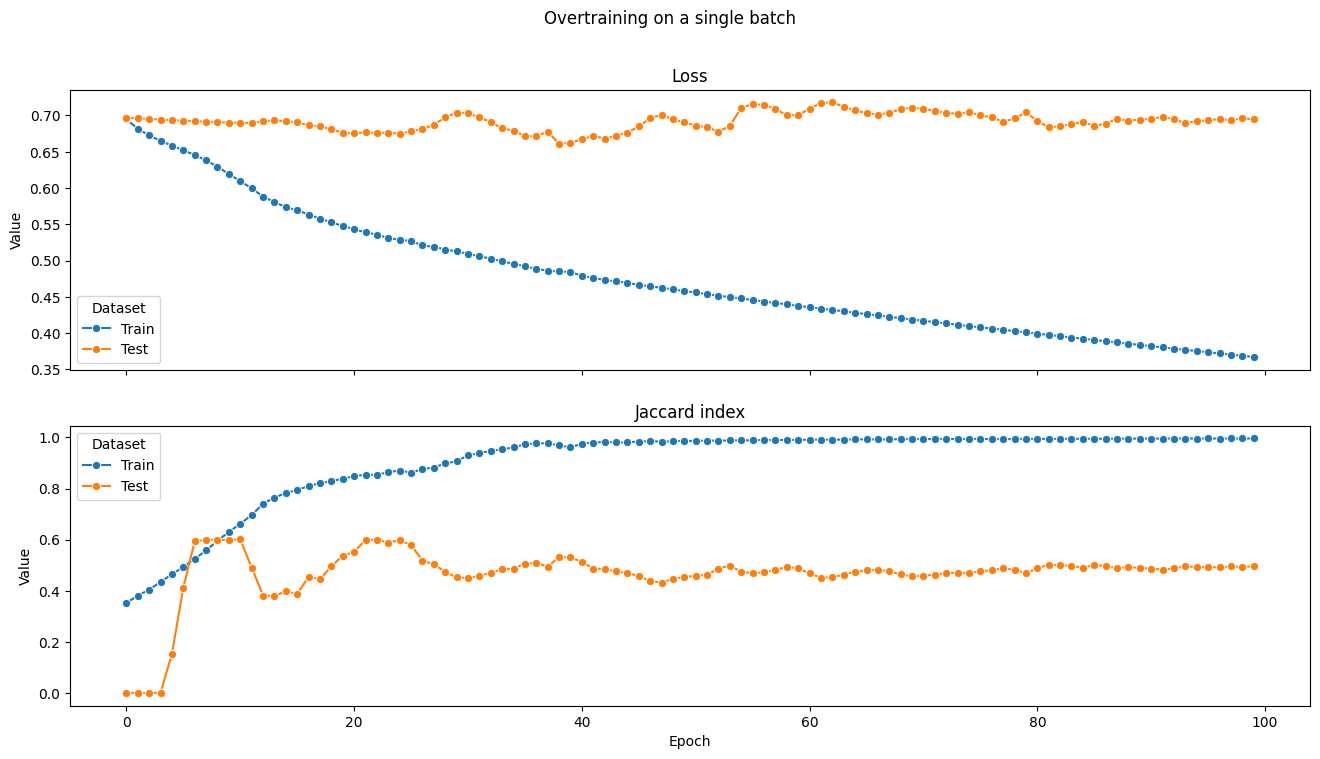

In [15]:
display_statistics(stats, "Overtraining on a single batch")

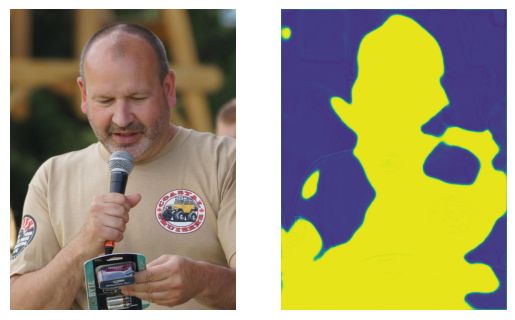

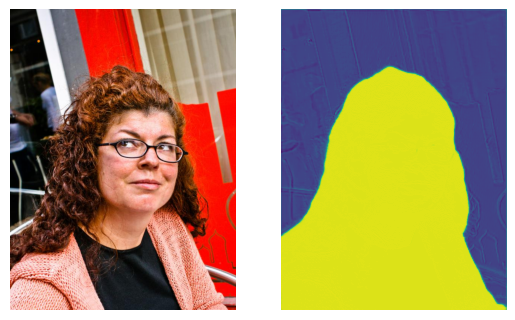

In [16]:
@torch.no_grad
def display_model_prediction(entry):
    model.eval()
    X = entry[0].cuda().unsqueeze(0)
    pred = model(X)[0].cpu()
    pred = nn.functional.sigmoid(pred)
    display_images([entry[0], pred])


display_model_prediction(test_dataset[0])
display_model_prediction(train_dataset[0])

Переобучившнись на одном батче, получаем на нем хороший результат, но плохой на тестовых данных, что и следовало ожидать

## Обучение

Модели занимают большое количество видеопамяти, ее необходимо переодически очищать, иначе не получится создавать, тренировать и использовать новые модели

Будем удалять все тензоры на GPU, а так же модель

Стоит быть осторожным, так как модель может называться не model, в таком случае надо предварительно сделать `del name_of_model`

`torch.cuda.empty_cache()` позволит освободить память из под тензоров и моделей

In [17]:
def free_gpu_mem():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and obj.is_cuda:
            del obj

    variables = globals().keys()
    if "model" not in variables: 
        print("Already clear")
        return

    global model
    del model
    torch.cuda.empty_cache()
    gc.collect()
    print("Cleared")


def free_mem():
    gc.collect()

free_gpu_mem()

Cleared


In [18]:
def train_initial_model():
    batch_size = 15

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    weights_save_dir = "./weights/initial"

    free_gpu_mem()
    model = UNET().cuda()
    optimizer = torch.optim.Adam(model.parameters())

    stats = train(model, optimizer, train_loader, test_loader, 30, weights_save_dir)

    stats.to_csv("./initial_stats.csv")


if (not os.path.isfile("./initial_stats.csv")):
    train_initial_model()


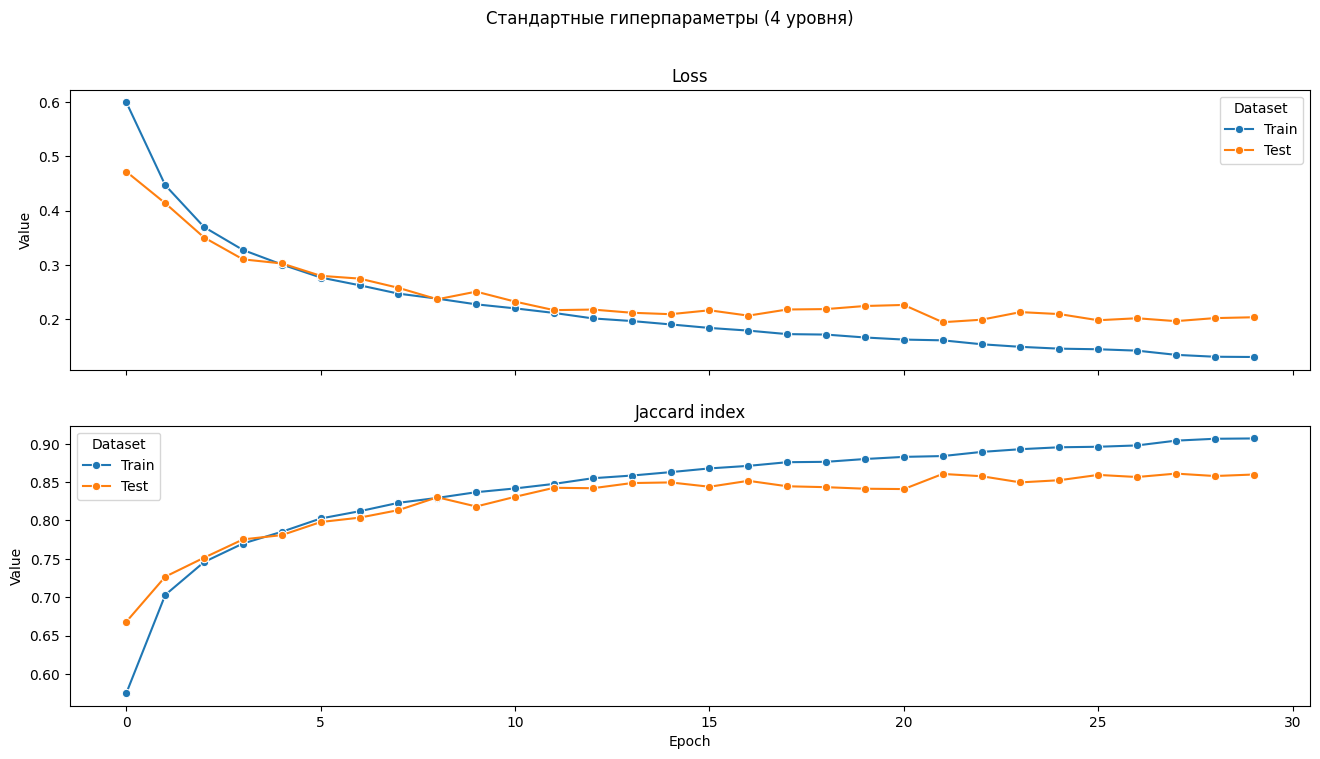

In [19]:
display_statistics(pd.read_csv("./initial_stats.csv"), "Стандартные гиперпараметры (4 уровня)")

Возьмем модель, у которой были зафиксированны лучшие результаты (на эпохе 26), и протестируем.

Для этого также создадим функцию, которая посчитает и покажет 2 лучших, 2 худших и 2 средних результата предсказания согласно jaccard index

In [20]:
@torch.no_grad
def pred_single(model, x):
    pred = model(x.cuda().unsqueeze(0))[0].cpu()
    sigma_pred = nn.functional.sigmoid(pred)
    del pred
    return sigma_pred

@torch.no_grad
def show_results_of_model(model, dataset=None):
    gc.collect() # Please
    if dataset is None:
        cropped_test_dataset = SliceDataset(test_dataset, 0, 100)
    else:
        cropped_test_dataset = SliceDataset(dataset, 0, 100)
    answers = []
    model.eval();
    for i, (x, y) in enumerate(cropped_test_dataset):
        pred = model(x.cuda().unsqueeze(0))[0].cpu()
        jaccard = jaccard_fn(pred.cpu(), y.cpu() > jaccard_fn.threshold)
        answers.append((i, jaccard))
        del pred

    answers.sort(key=lambda x: -x[1])
    worst_two = answers[-3:-1:1]
    best_two = answers[0:2:1]
    between = [answers[int(len(answers) / 2)]]
    between.append(answers[int(len(answers) / 2) + 1])


    worst_images = [cropped_test_dataset[worst_two[0][0]][0], None, cropped_test_dataset[worst_two[1][0]][0], None]
    worst_images[1] = pred_single(model, cropped_test_dataset[worst_two[0][0]][0])
    worst_images[3] = pred_single(model, cropped_test_dataset[worst_two[1][0]][0])

    display_images(worst_images)

    middle_images = [cropped_test_dataset[between[0][0]][0], None, cropped_test_dataset[between[1][0]][0], None]
    middle_images[1] = pred_single(model, cropped_test_dataset[between[0][0]][0])
    middle_images[3] = pred_single(model, cropped_test_dataset[between[1][0]][0])

    display_images(middle_images)

    best_images = [cropped_test_dataset[best_two[0][0]][0], None, cropped_test_dataset[best_two[1][0]][0], None]
    best_images[1] = pred_single(model, cropped_test_dataset[best_two[0][0]][0])
    best_images[3] = pred_single(model, cropped_test_dataset[best_two[1][0]][0])

    display_images(best_images)

    for ans in range(len(answers)):
        try: del answers[ans]
        except Exception: pass
    
    gc.collect()


Already clear


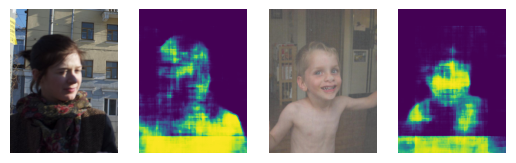

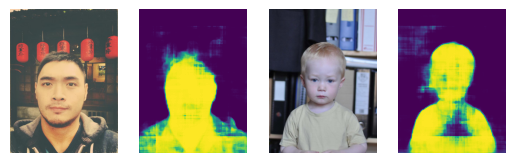

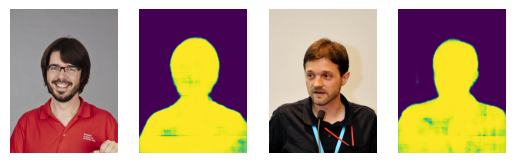

In [21]:
free_gpu_mem()
free_mem()
model = UNET()
model.load_state_dict(torch.load(f"weights/initial/weights_26.bin"))
model.cuda().eval();
show_results_of_model(model)

Самые лучше результаты были получены на простых фотографиях с монотонным фоном, в то время как самые плохие результаты были получены при нестандартном освещении и сложном фоне.

На картинках присутствуют странные артефакты

## Улучшения без изменения архитектуры
Сначала попробуем расширить датасет с помощью аугментации

Добавим 2 трансофрмации
- Геометрическую (гарантированное отражение по горизонтали)
- Цветную (небольшое изменение цвета и резкости картинки)

С помощью класса AugmentedDataset применим преобразования к картинкам, не меняя содержательность масок

In [22]:
filters_flip = [transforms.RandomHorizontalFlip(p=1)]
filters_color = [
    transforms.ColorJitter(brightness=.05, hue=.05, saturation=.05),
    transforms.RandomAdjustSharpness(sharpness_factor=6),
]

augmentations_flip = transforms.Compose(filters_flip)
augmentations_color = transforms.Compose(filters_color)

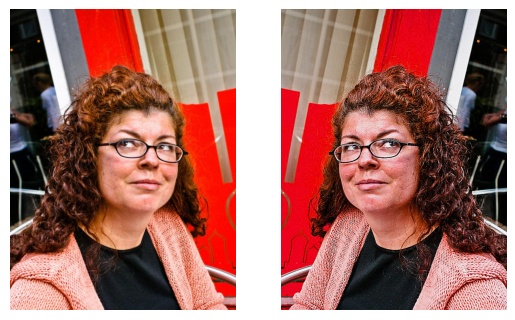

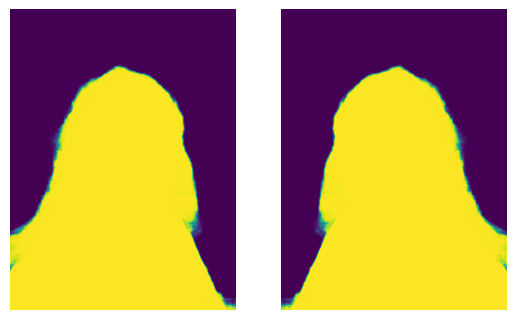

In [23]:
train_dataset_augmented = AugmentedDataset(train_dataset, augmentations_flip, augmentations_color)

image, mask = train_dataset[0]
augmented_image, augmented_mask = train_dataset_augmented[0]
display_images([image, augmented_image])
display_images([mask, augmented_mask])

train_dataset_full = torch.utils.data.ConcatDataset([train_dataset, copy(train_dataset)])

## Обучение
Помимо датасета, попробуем разное количество уровней, 2, 4, 6 и 8.

model_2_levels.csv is Already done
model_4_levels.csv is Already done
model_6_levels.csv is Already done
model_8_levels.csv is Already done


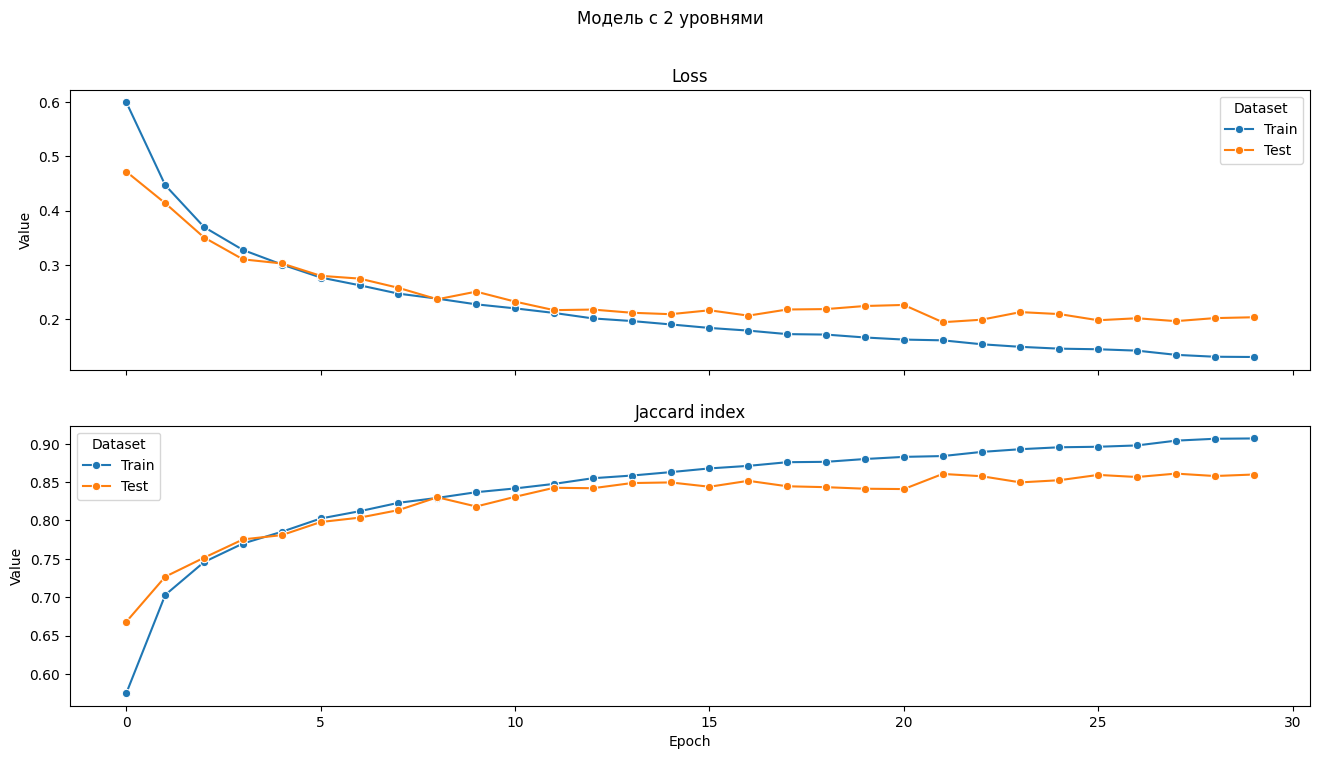

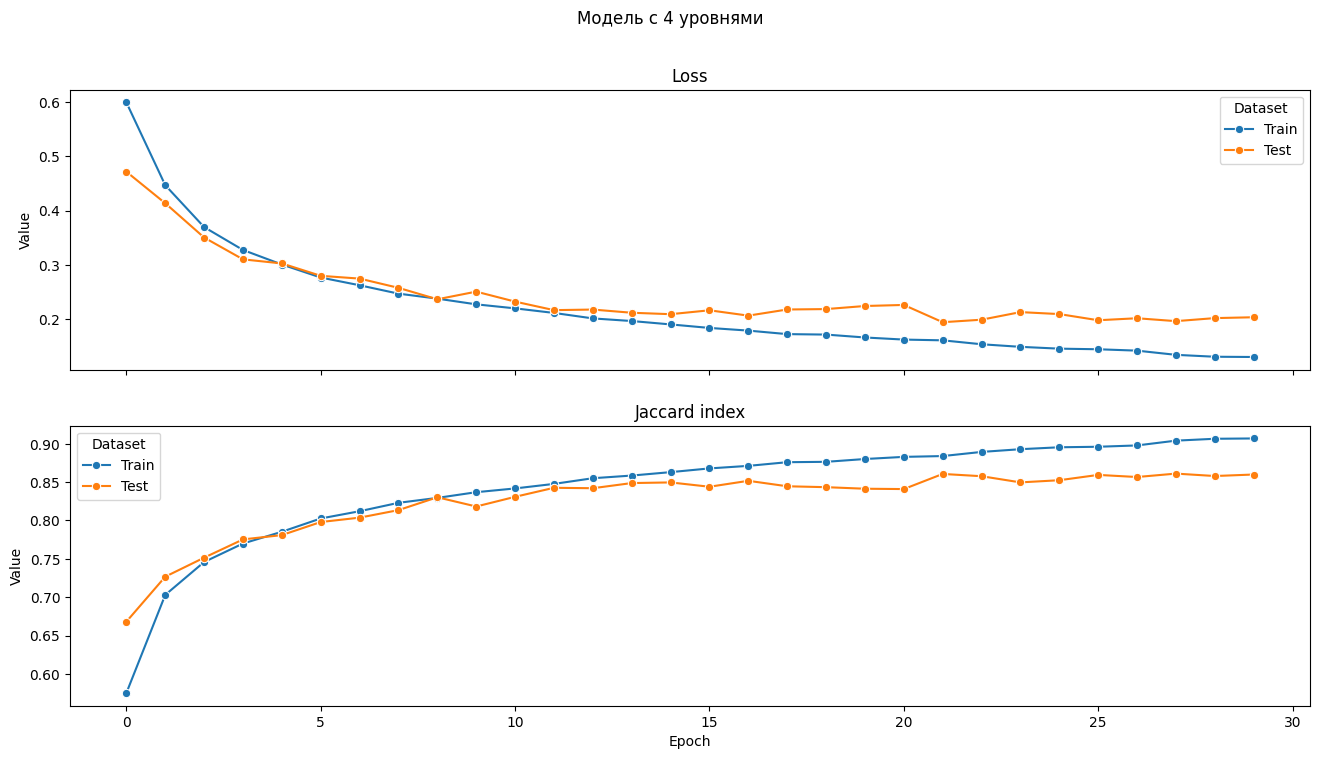

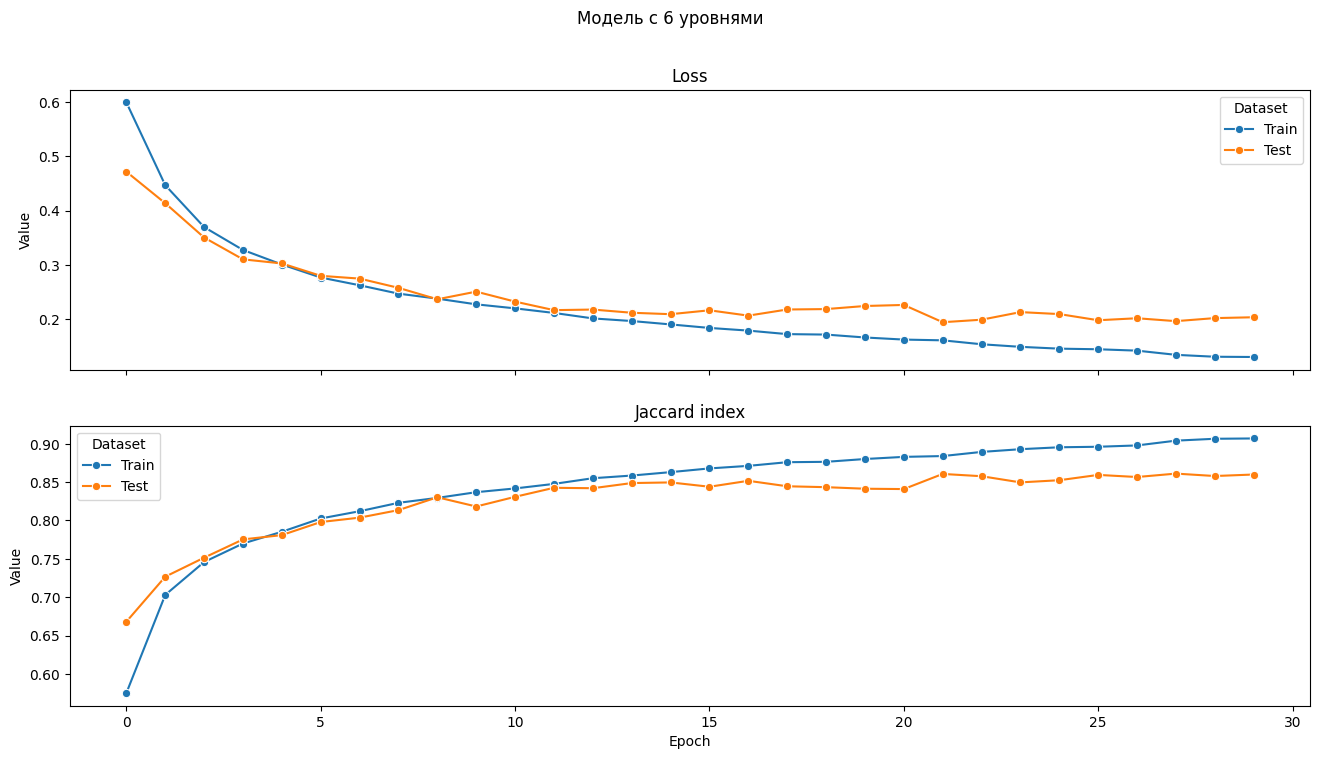

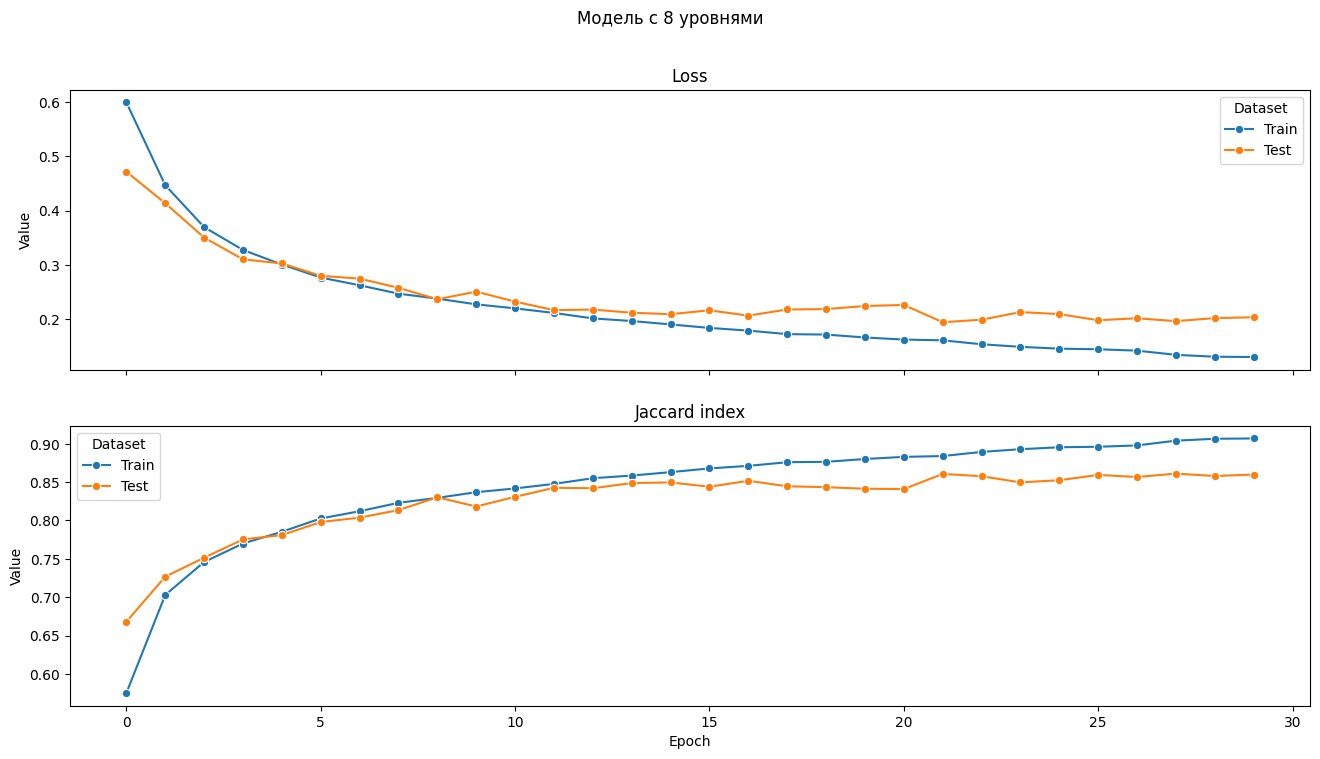

In [24]:
searched_levels = [2, 4, 6, 8]

train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for num_levels in searched_levels:
    if (os.path.isfile(f"model_{num_levels}_levels.csv")):
        print(f"model_{num_levels}_levels.csv is Already done")
        continue

    free_gpu_mem()
    weights_dir = f"./weights/model_{num_levels}_levels"
    model = UNET(n_levels=num_levels).cuda()
    optimizer = torch.optim.Adam(model.parameters())

    stats = train(model, optimizer, train_loader_full, test_loader, 30, weights_dir)
    stats.to_csv(f"model_{num_levels}_levels.csv")

for num_levels in searched_levels:
    stats = pd.read_csv("./initial_stats.csv")
    display_statistics(stats, f"Модель с {num_levels} уровнями")

## Тестирование
Протестируем получившиеся модели

### Модель с 2 уровнями

Cleared


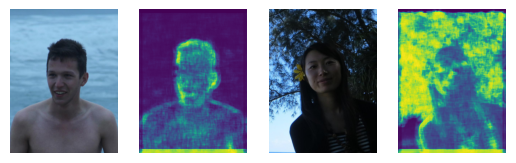

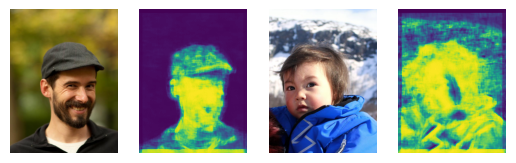

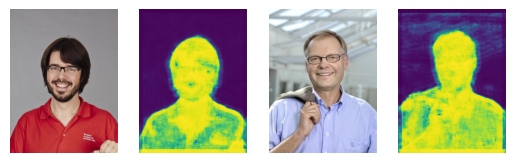

In [25]:
free_gpu_mem()
free_mem()
model = UNET(n_levels=2)
model.load_state_dict(torch.load(f"weights/model_2_levels/weights_24.bin"))
model.cuda().eval();
show_results_of_model(model)

### Модель с 4 уровнями

Cleared


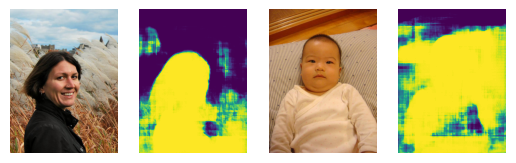

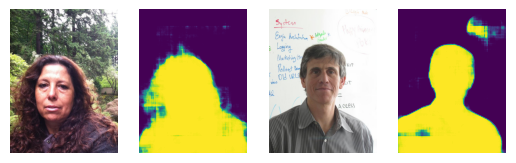

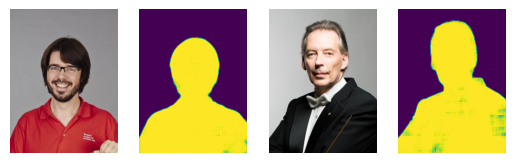

In [26]:
free_gpu_mem()
free_mem()
model = UNET(n_levels=4)
model.load_state_dict(torch.load(f"weights/model_4_levels/weights_25.bin"))
model.cuda().eval();
show_results_of_model(model)

### Модель с 6 уровнями

Cleared


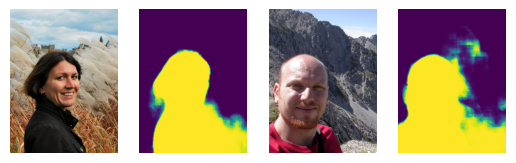

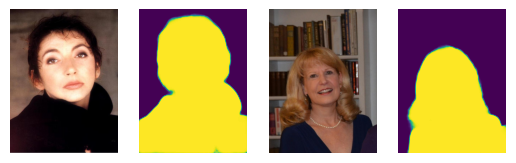

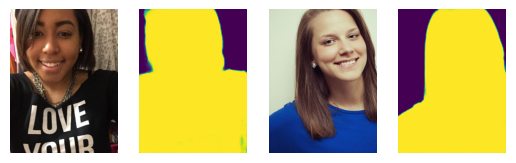

In [27]:
free_gpu_mem()
free_mem()
model = UNET(n_levels=6)
model.load_state_dict(torch.load(f"weights/model_6_levels/weights_25.bin"))
model.cuda().eval();
show_results_of_model(model)

### Модель с 8 уровнями

Cleared


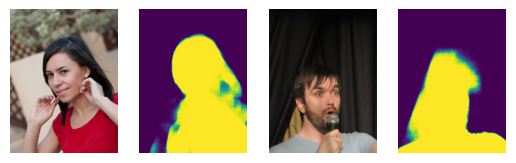

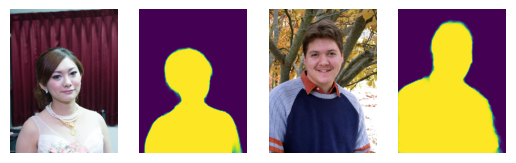

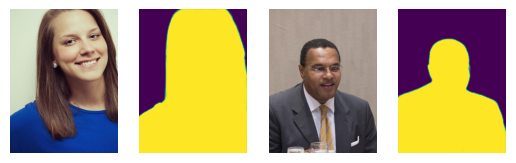

In [28]:
free_gpu_mem()
free_mem()
model = UNET(n_levels=8)
model.load_state_dict(torch.load(f"weights/model_8_levels/weights_27.bin"))
model.cuda().eval();
show_results_of_model(model)

Чем больше уровней, тем более резкие и правильные получаются изображения

## Test-time аугментации (Horisontal Flip)
Попробуем улучшить точность, модифицируя работу сети.

На вход подадим оригинально изображение и отраженное, а затем развернем получившуюся вторую маску и усредним ответы.

Для этого сделаем класс-декоратор для нашей сети с описанной функциональностью

In [29]:
class AugmentedReinforcedInputModel(nn.Module):
    def __init__(self, base_model, geometry_transform):
        super().__init__()
        self._base_model = base_model
        self._transform = geometry_transform
    
    def forward(self, x):
        x = copy(x)
        x_transformed = self._transform(x)
        y = self._base_model(x)
        y_transformed = self._base_model(x_transformed)
        y_restored = self._transform(y_transformed)
        stacked = torch.stack([y, y_restored])
        means = torch.mean(stacked, dim=0)
        return means

Cleared


Модель без декоратора: Loss: 0.050, Jaccard: 0.972
Модель с декоратором: Loss: 0.044, Jaccard: 0.974
Худшие, средние и лучшие результаты для UNET


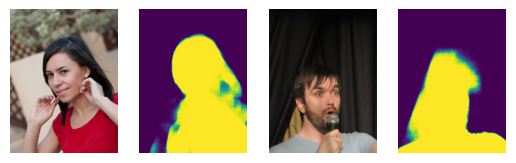

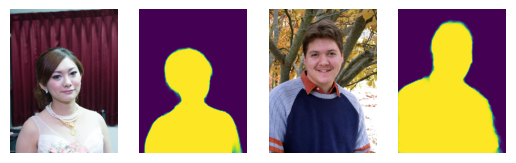

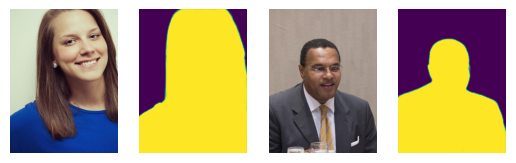

Худшие, средние и лучшие результаты для UNET, с аугментированным входом


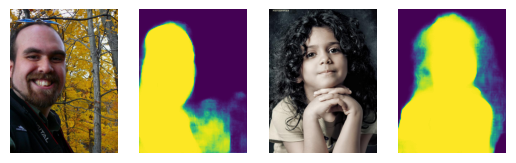

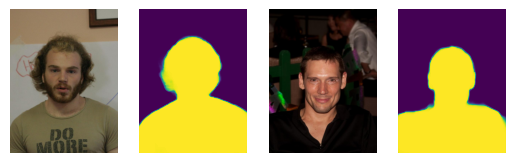

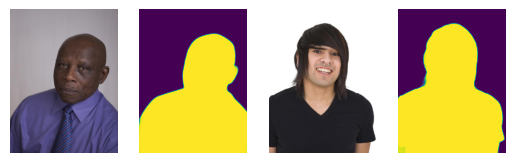

In [30]:
free_gpu_mem()
free_mem()
model = UNET(n_levels=8)
model.load_state_dict(torch.load(f"weights/model_8_levels/weights_27.bin"))
model.cuda().eval();
ari_model = AugmentedReinforcedInputModel(model, augmentations_flip)

model_loss, model_jaccard = test(model, test_loader)
ari_model_loss, ari_model_jaccard = test(ari_model, test_loader)

print(f"Модель без декоратора: Loss: {model_loss:.3f}, Jaccard: {model_jaccard:.3f}")
print(f"Модель с декоратором: Loss: {ari_model_loss:.3f}, Jaccard: {ari_model_jaccard:.3f}")

print("Худшие, средние и лучшие результаты для UNET")
show_results_of_model(model)
print("Худшие, средние и лучшие результаты для UNET, с аугментированным входом")
show_results_of_model(ari_model)

del ari_model

Модель с test-time аугментацией показала результаты чуть лучше, но все равно не сильно отличается от обычной модели

## Изменения архитектуры

Добавим несколько слоев для ConvBlock, а также слой DropOut, чтобы бороться с overfitting.

In [31]:
class ModifiedConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, hidden_channels : int, padding: int):
        super().__init__()
        
        in_conv = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2)
        ]

        hidden_conv = []

        for _ in range(3):
            hidden_conv.append(nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=padding, bias=False))
            hidden_conv.append(nn.BatchNorm2d(out_channels))
            hidden_conv.append(nn.ReLU(inplace=True))

        out_conv = [
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        self.double_conv_block = nn.Sequential(
            *[*in_conv, *hidden_conv, *out_conv]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv_block(x)


class ModifiedEncoder(nn.Module):
    def __init__(self, in_channels: int, n_down: int, channels_factor: int = 2, padding: int = 1):
        super().__init__()

        self.enc_layers = nn.ModuleList(
            [ModifiedConvBlock(in_channels, in_channels * channels_factor, in_channels * channels_factor, padding)]
        )
        for _ in range(n_down):
            in_channels *= channels_factor
            self.enc_layers.append(
                nn.Sequential(
                    nn.MaxPool2d(2, 2),
                    DoubleConvBlock(in_channels, in_channels * channels_factor, padding),
                )
            )

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        results = []
        for layer in self.enc_layers:
            x = layer(x)
            results.append(x)
        return results


class ModifiedDecoder(nn.Module):
    def __init__(self, in_channels: int, n_up: int, channels_divisor: int = 2, padding: int = 1):
        super().__init__()

        self.dec_layers = nn.ModuleList()
        for _ in range(n_up):
            out_channels = in_channels // channels_divisor
            self.dec_layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                DoubleConvBlock(in_channels, out_channels, padding),
            ]
            in_channels = out_channels

    def forward(self, x: torch.Tensor, residuals: list[torch.Tensor]) -> torch.Tensor:
        assert len(residuals) == len(self.dec_layers) // 2
        for (up_conv, double_conv), residual in zip(zip(self.dec_layers[::2], self.dec_layers[1::2]), residuals[::-1]):
            x = up_conv(x)

            # H and W of resudial may be greater by 1 if the initial resolution was not divisible by 2 ^ n_levels
            h_diff = residual.size(dim=2) - x.size(dim=2)
            assert 0 <= h_diff <= 1
            w_diff = residual.size(dim=3) - x.size(dim=3)
            assert 0 <= w_diff <= 1
            if h_diff > 0 or w_diff > 0:
                x = nn.functional.pad(x, [0, w_diff, 0, h_diff])

            x = torch.cat([residual, x], dim=1)

            x = double_conv(x)
        return x


class ModifiedUNET(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1, n_levels: int = 4):
        super().__init__()
        self.encoder = ModifiedEncoder(in_channels=in_channels, n_down=n_levels)
        self.decoder = ModifiedDecoder(in_channels=in_channels * (2 ** (n_levels + 1)), n_up=n_levels)
        self.out_conv = nn.Conv2d(in_channels=in_channels * 2, out_channels=out_channels, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        *residuals, x = self.encoder(x)
        x = self.decoder(x, residuals)
        x = self.out_conv(x)
        return x

In [32]:
free_gpu_mem()
free_mem()


def train_modified_model():
    batch_size = 10

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    weights_save_dir = "./weights/modified"

    free_gpu_mem()
    model = ModifiedUNET(n_levels=8).cuda()
    optimizer = torch.optim.Adam(model.parameters())

    stats = train(model, optimizer, train_loader, test_loader, 30, weights_save_dir)

    stats.to_csv("./modified_stats.csv")


if (not os.path.isfile("./modified_stats.csv")):
    train_modified_model()

Cleared


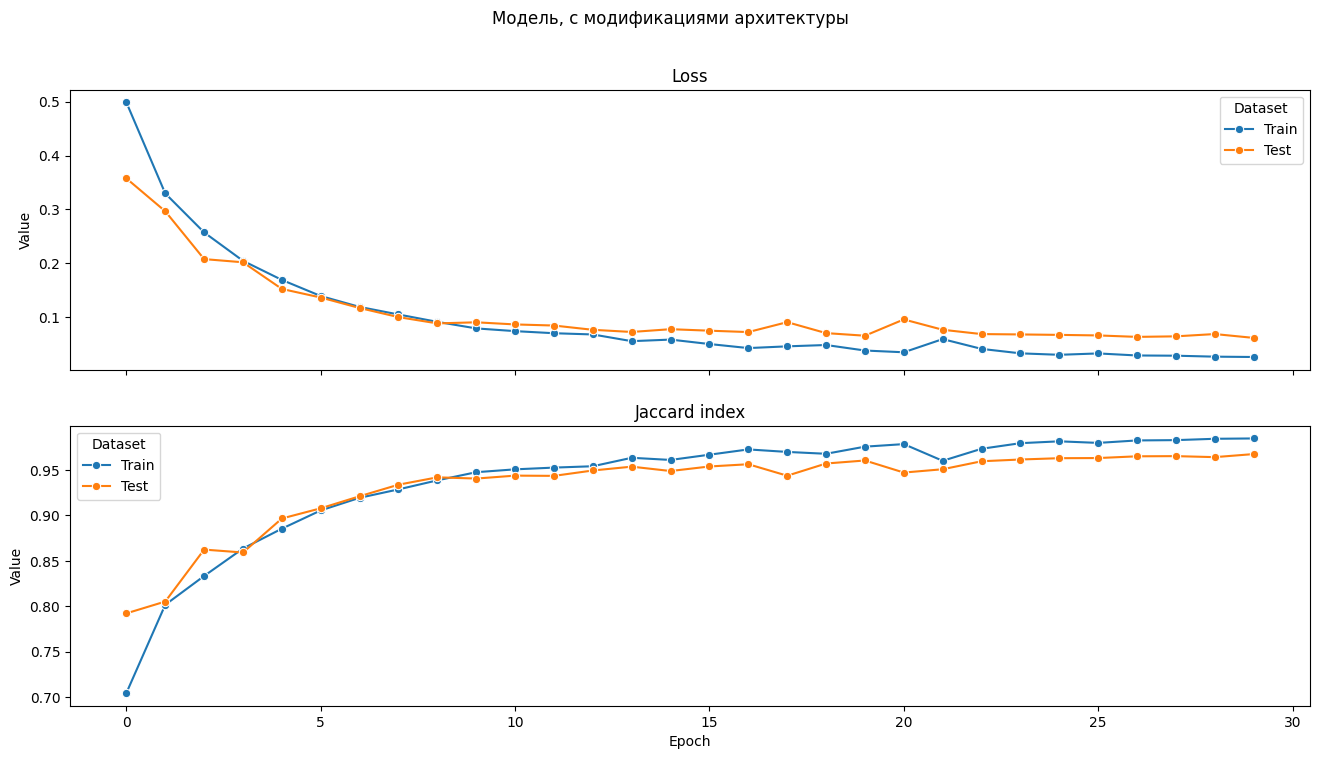

In [33]:
display_statistics(pd.read_csv("./modified_stats.csv"), "Модель, с модификациями архитектуры")

Already clear


Модифицированная модель: Loss: 0.063, Jaccard: 0.965


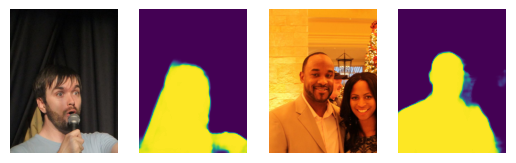

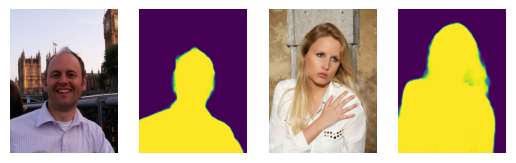

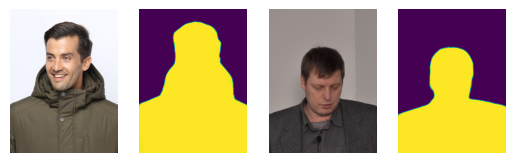

In [34]:
free_gpu_mem()
free_mem()
model = ModifiedUNET(n_levels=8)
model.load_state_dict(torch.load(f"weights/modified/weights_26.bin"))
model.cuda().eval();

modified_model_loss, modified_model_jaccard = test(model, test_loader)
print(f"Модифицированная модель: Loss: {modified_model_loss:.3f}, Jaccard: {modified_model_jaccard:.3f}")

show_results_of_model(model)

## Обучение, используя 5Fold

Сделаем 5fold на тренировочном датасете и посмотрим на результаты тренировок

In [35]:
from sklearn.model_selection import KFold

five_fold = KFold(n_splits=5)
batch_size = 15

for index, (train_indices, test_indices) in enumerate(five_fold.split(train_dataset)):
    if (os.path.isfile(f"kfold_{index}_stats.csv")): continue

    free_gpu_mem()
    model = UNET(n_levels=8)
    model = model.cuda()
    train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_indices), batch_size=batch_size)
    
    optimizer = torch.optim.Adam(model.parameters())
    stats = train(model, optimizer, train_loader, test_loader, 30, f"weights/kfolds/kfolds_{index}")
    stats.to_csv(f"kfold_{index}_stats.csv")


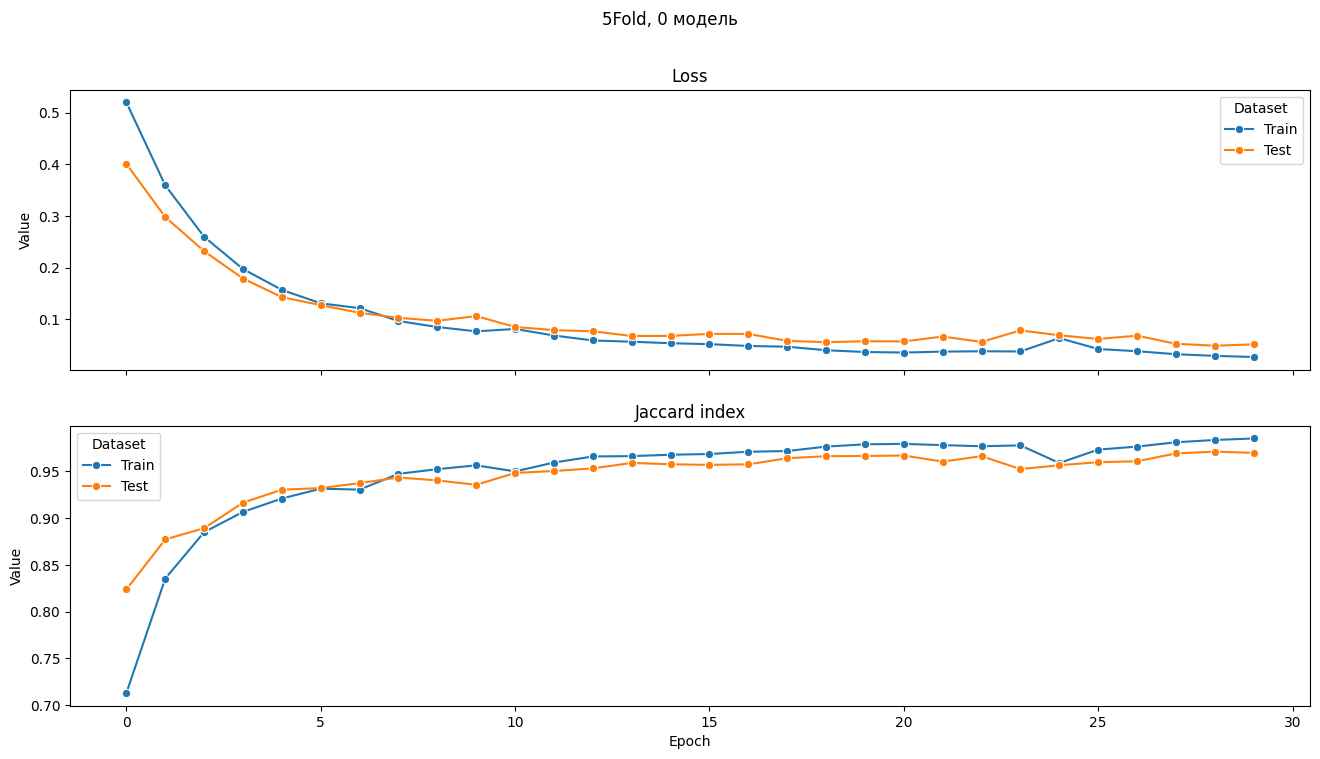

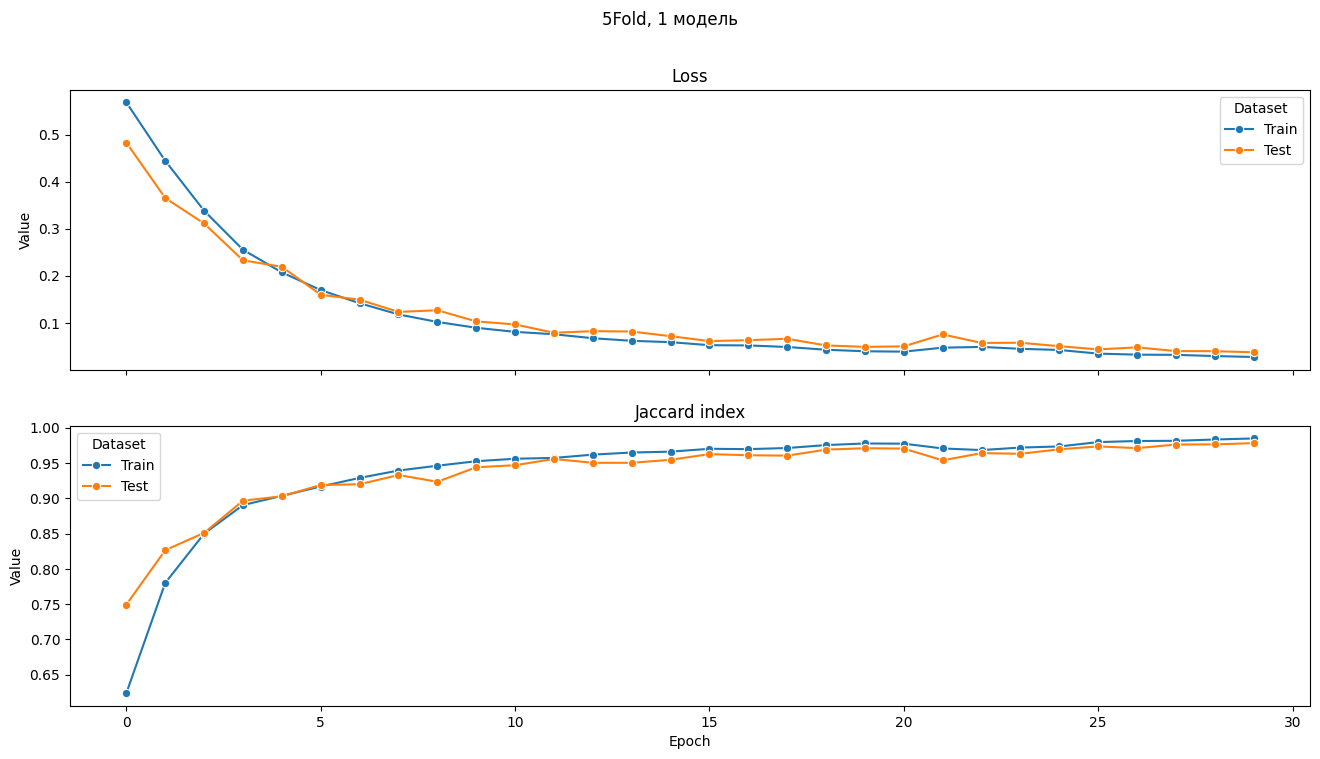

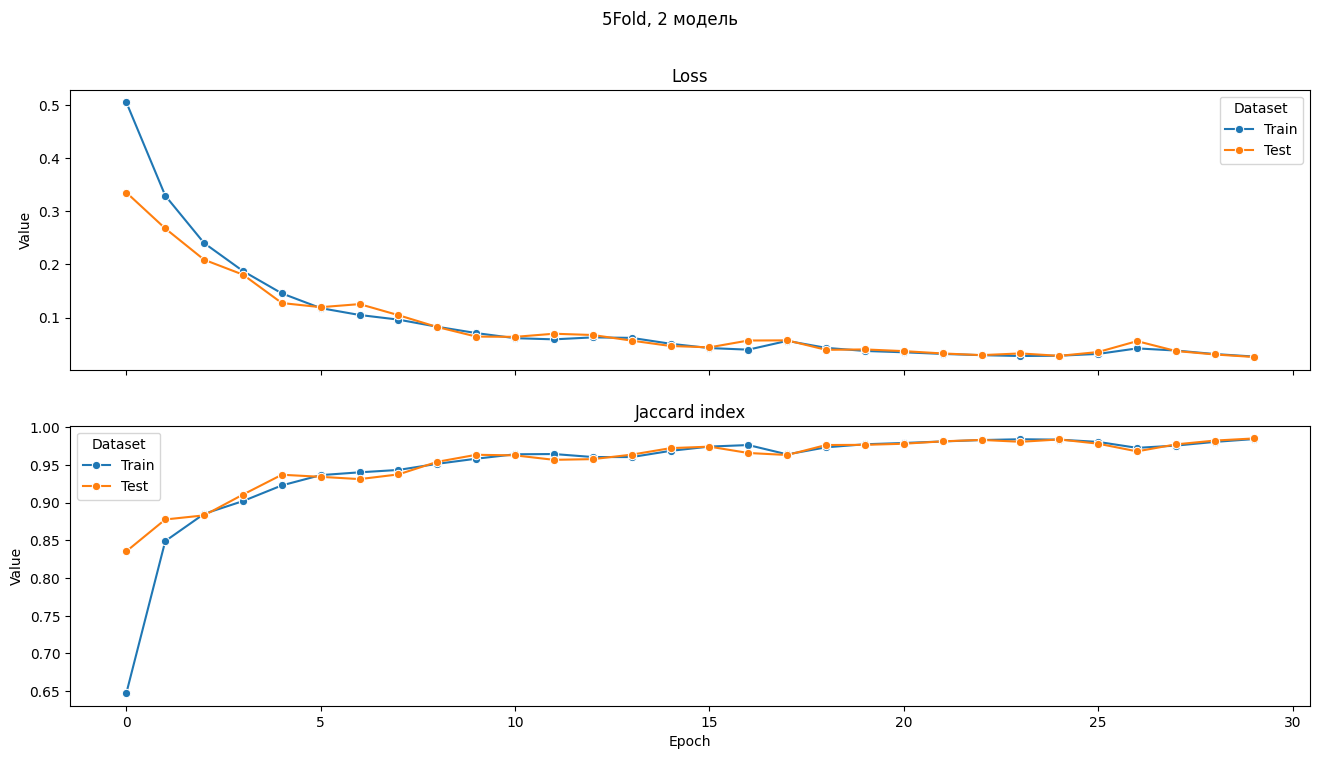

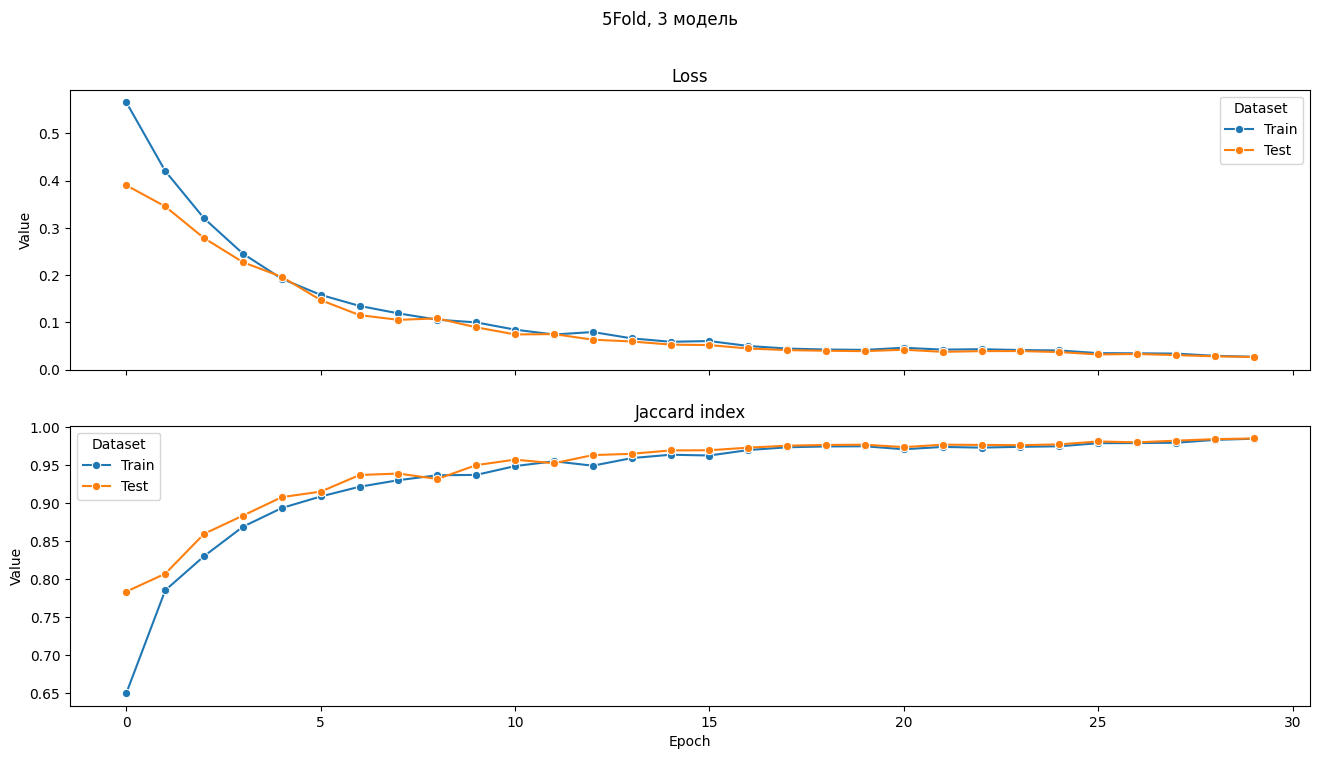

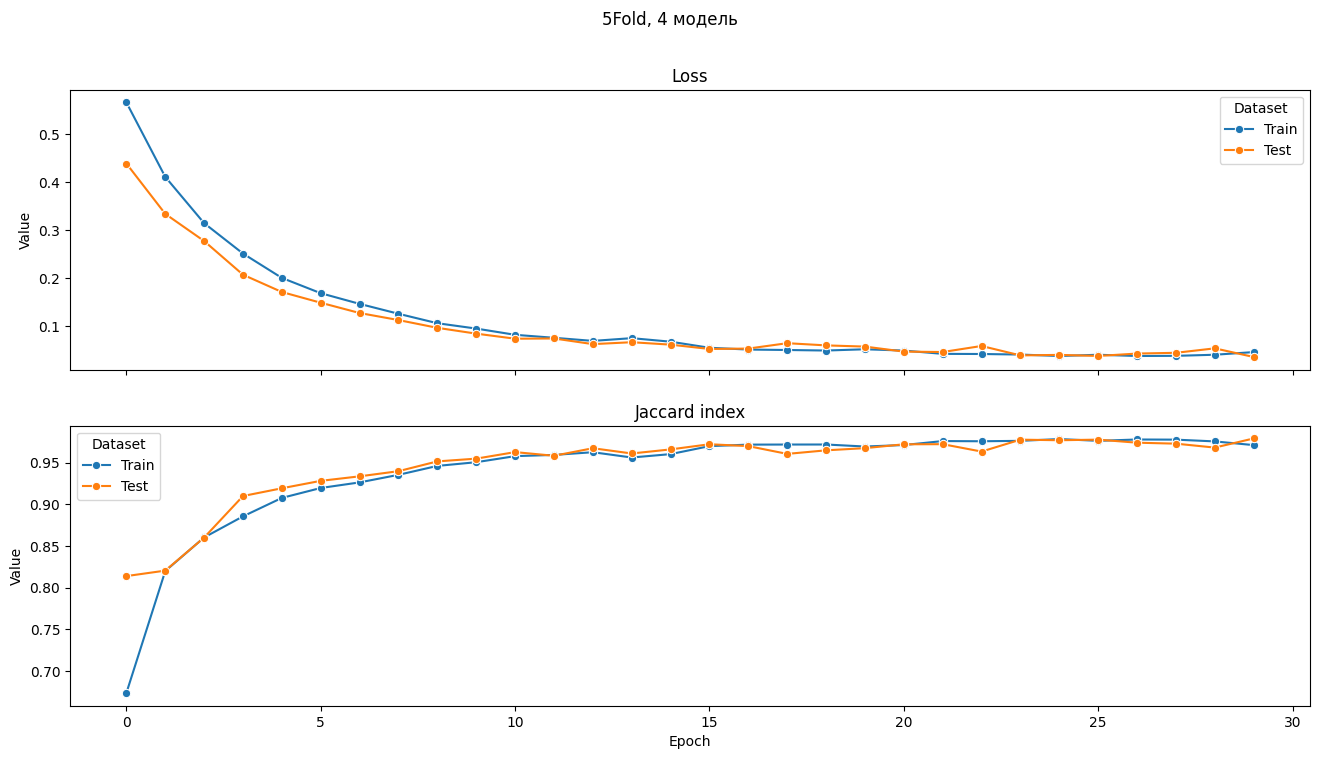

In [36]:
for index in range(5):
    stats = pd.read_csv(f"./kfold_{index}_stats.csv")
    display_statistics(stats, f"5Fold, {index} модель")

## Результаты и сравнения моделей 5fold

Cleared
text


5Folds, 0 модель: Loss: 0.054, Jaccard: 0.968


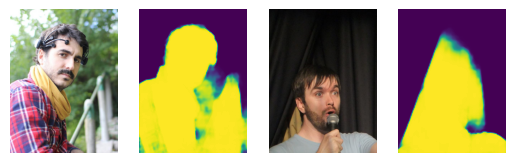

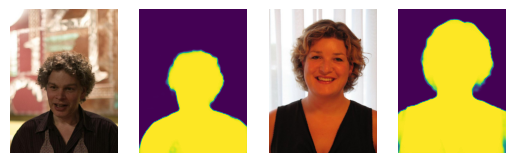

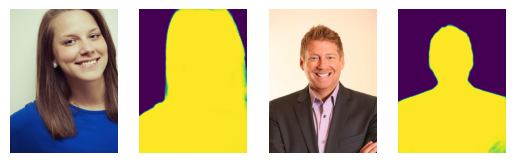

Already clear
text


5Folds, 1 модель: Loss: 0.065, Jaccard: 0.963


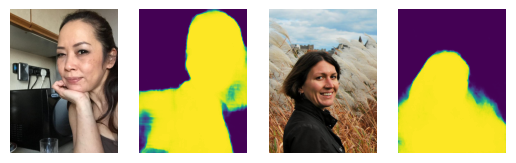

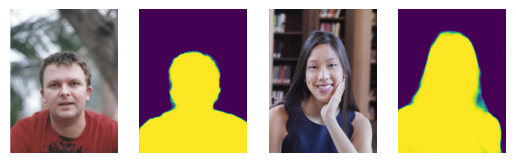

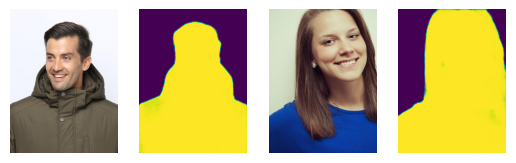

Already clear
text


5Folds, 2 модель: Loss: 0.052, Jaccard: 0.969


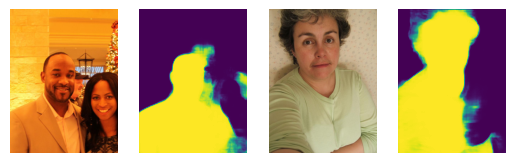

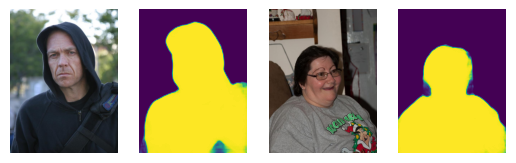

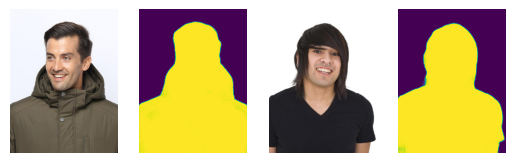

Already clear
text


5Folds, 3 модель: Loss: 0.059, Jaccard: 0.966


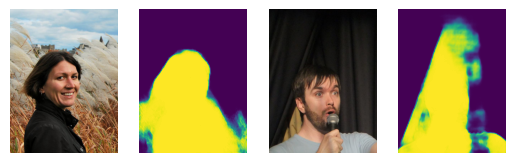

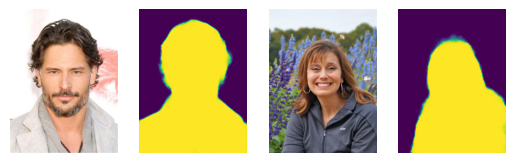

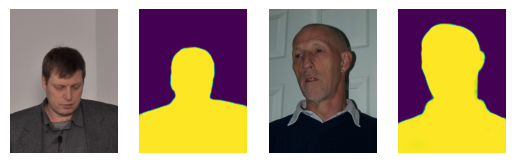

Already clear
text


5Folds, 4 модель: Loss: 0.062, Jaccard: 0.962


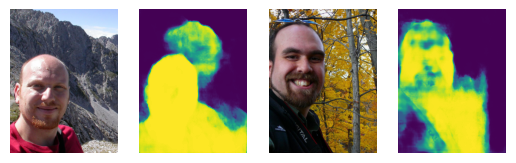

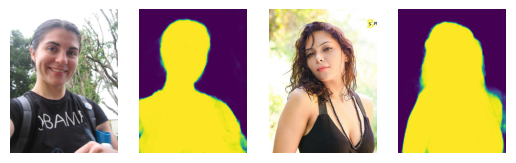

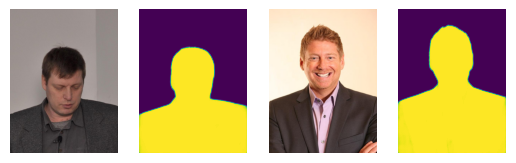

In [37]:
batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size)

def test_and_print(weights, text):
    free_gpu_mem()
    free_mem()
    model = UNET(n_levels=8)
    model.load_state_dict(torch.load(weights))
    model.cuda().eval();
    model_loss, model_jaccard = test(model, test_loader)
    print(f"{text}: Loss: {model_loss:.3f}, Jaccard: {model_jaccard:.3f}")
    show_results_of_model(model)

test_and_print("weights/kfolds/kfolds_0/weights_28.bin", "5Folds, 0 модель")
test_and_print("weights/kfolds/kfolds_1/weights_29.bin", "5Folds, 1 модель")
test_and_print("weights/kfolds/kfolds_2/weights_29.bin", "5Folds, 2 модель")
test_and_print("weights/kfolds/kfolds_3/weights_29.bin", "5Folds, 3 модель")
test_and_print("weights/kfolds/kfolds_4/weights_29.bin", "5Folds, 4 модель")

В результате разбиения датасета на 5 частей и тренировке на них, наблюдаются следующие факты.

- Не смотря на то, что тренировка проходила на разных картинках, общие принципы для плохого или хорошего результата сохраняются
  - Контрастные картинки с однородным задним фоном имеют наилучший результат
  - Картинки с нетрудным фоном и хорошим освещением получают адекватный результат
  - Картинки со сложным фоном, а так же с плохим освещением имеют наихудший результат
- Частно, наихудшие картинки пересекаются между разными итерациями
  - Связано это, скорее всего, с объективной сложностью их сегментации
- Все итерации показали неплохие результаты, почти не отличающиеся друг от друга
- Все итерации не сильно отличаются от модели, обученной на всем датасете

## UNET с предобученым энкодером
В качестве предобученного энкодера использую ResNet 34

In [38]:
import segmentation_models_pytorch as smp

In [39]:
def train_pretrained_encoder_model():
    batch_size = 8

    padded_train_dataset = PaddedDataset(train_dataset)
    padded_test_dataset = PaddedDataset(train_dataset)

    train_loader = DataLoader(padded_train_dataset, batch_size=batch_size)
    test_loader = DataLoader(padded_test_dataset, batch_size=batch_size)
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        activation=None
    ).cuda()
    optimizer = torch.optim.Adam(model.parameters())

    stats = train(model, optimizer, train_loader, test_loader, 30, "weights/pretrained")

    stats.to_csv("./pretrained_stats.csv")


if (not os.path.isfile("./pretrained_stats.csv")):
    train_pretrained_encoder_model()


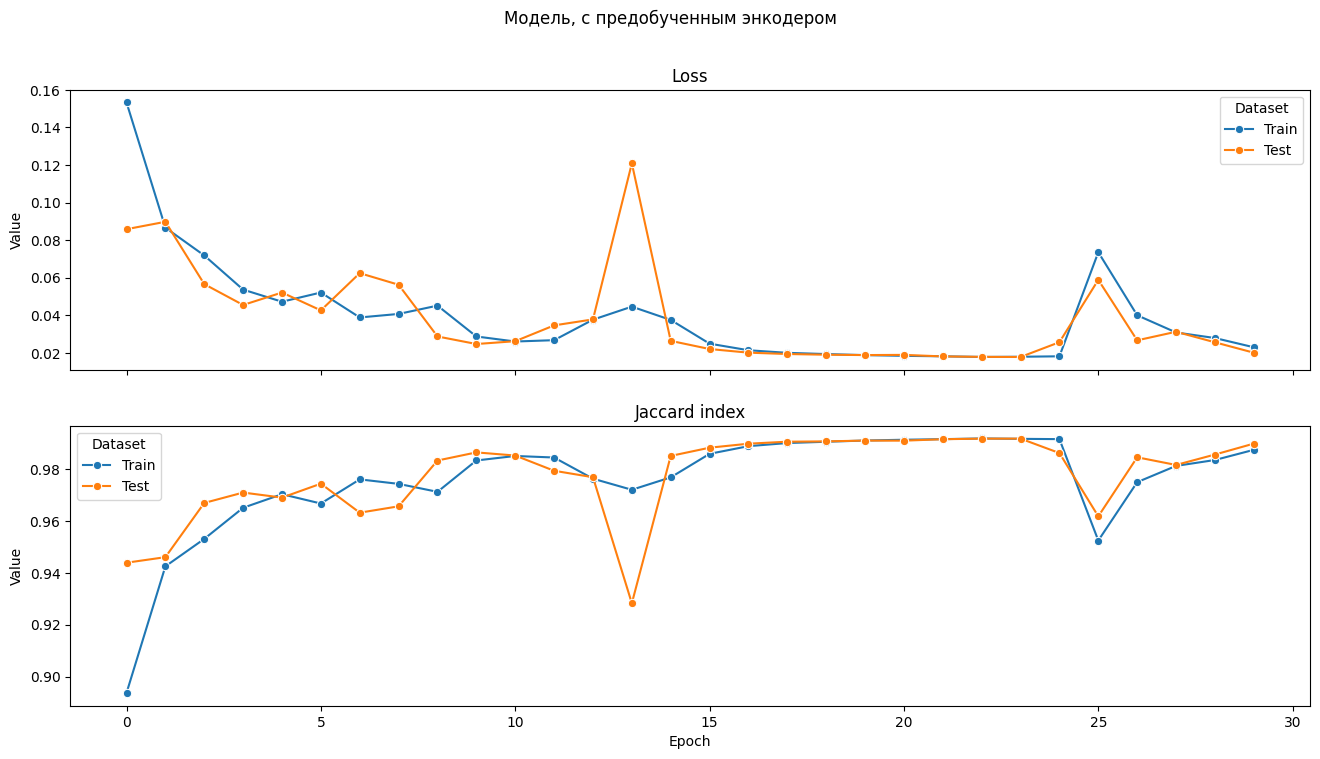

In [40]:
display_statistics(pd.read_csv("./pretrained_stats.csv"), "Модель, с предобученным энкодером")

Already clear


Предобученная модель: Loss: 0.035, Jaccard: 0.981


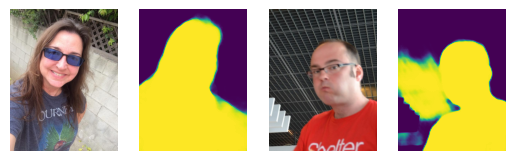

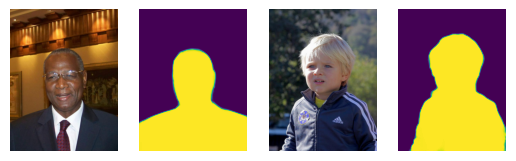

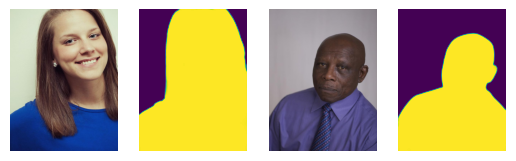

In [41]:
free_gpu_mem()
free_mem()
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    activation=None
).cuda()

model.load_state_dict(torch.load(f"weights/pretrained/weights_23.bin"))
model.cuda().eval();

padded_test_dataset = PaddedDataset(test_dataset)
test_loader = DataLoader(padded_test_dataset, batch_size=batch_size)
modified_model_loss, modified_model_jaccard = test(model, test_loader)
print(f"Предобученная модель: Loss: {modified_model_loss:.3f}, Jaccard: {modified_model_jaccard:.3f}")

show_results_of_model(model, padded_test_dataset)

Модель с предобученнм энкодером показала численно лучшие результаты, и по картинкам это тоже можно наблюдать

## Выводы

При изменениях, сделанных у моделей, все, за исключением добавления уровней показали примерно одинаковые хорошие результаты

В основном, проблемы, которые возникали, были из-за сложных картинок в датасете
- С неоднородным фоном
- С плохим освещением
- Со странными пропорциями
- С чертами лица, сливающимися с задним фоном
- С наличием двух человек или рук на фото

Лучшими изменениями показали себя использование предобученного энкодера, а так же модель с восьмью уровнями

Аугментация датасета, изменения модели, test-time модификации помогли улучшить результат, но совсем немного

В результате тренировки 5 моделей на 5fold результаты были похожие и по-прежнему зависили в основном от вышеперечисленных факторов